In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import List, Optional, Tuple

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import string_functions as stringr
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 332
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data preparation (coppied)

In [3]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

data = data.sort_values(["hugo_symbol", "sgrna", "depmap_id"]).reset_index(drop=True)
for col in ("hugo_symbol", "depmap_id", "sgrna", "lineage", "chromosome"):
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data["log2_cn"] = np.log2(data.gene_cn + 1)
data = dphelp.zscale_cna_by_group(
    data, gene_cn_col="log2_cn", new_col="z_log2_cn", cn_max=np.log2(10)
)
data["is_mutated"] = dphelp.nmutations_to_binary_array(data.n_muts)

---

### Model 7. Introduce a covariate for the KRAS allele to model 6

Finally, we can add a categorical variable for the *KRAS* allele of a tumor sample.

In [4]:
gene_idx, num_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(data, "sgrna")

sgrna_to_gene_map = data[["sgrna", "hugo_symbol"]].drop_duplicates()
sgrna_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")

In [5]:
with pm.Model() as m7:
    # Indices
    sgrna_gene_idx_shared = pm.Data("sgrna_gene_idx", sgrna_gene_idx)
    sgrna_idx_shared = pm.Data("sgrna_idx_shared", sgrna_idx)
    gene_idx_shared = pm.Data("gene_idx_shared", gene_idx)

    # Data
    is_mutated_shared = pm.Data(
        "is_mutated_shared", dphelp.extract_flat_ary(data.is_mutated)
    )
    scaled_log2_cn_shared = pm.Data(
        "scaled_log2_cn_shared", dphelp.extract_flat_ary(data.z_log2_cn)
    )
    lfc_shared = pm.Data("lfc_shared", dphelp.extract_flat_ary(data.lfc))

    μ_g = pm.Normal("μ_g", 0, 5)
    σ_g = pm.Exponential("σ_g", 1)

    g_s = pm.Normal("g_s", μ_g, σ_g, shape=num_genes)

    μ_α_s = pm.Deterministic("μ_α_s", g_s[sgrna_gene_idx_shared])
    σ_α_s = pm.Exponential("σ_α_s", 1)
    μ_γ_g = pm.Normal("μ_γ_g", 0, 2)
    σ_γ_g = pm.HalfNormal("σ_γ_g", 2)
    μ_δ_g = pm.Normal("μ_δ_g", 0, 2)
    σ_δ_g = pm.HalfNormal("σ_δ_g", 2)

    α_s = pm.Normal("α_s", μ_α_s, σ_α_s, shape=num_sgrnas)
    γ_g = pm.Normal("γ_g", μ_γ_g, σ_γ_g, shape=num_genes)
    δ_g = pm.Normal("δ_g", μ_δ_g, σ_δ_g, shape=num_genes)

    μ = pm.Deterministic(
        "μ",
        α_s[sgrna_idx_shared]
        + γ_g[gene_idx_shared] * is_mutated_shared
        + δ_g[gene_idx_shared] * scaled_log2_cn_shared,
    )
    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=lfc_shared)

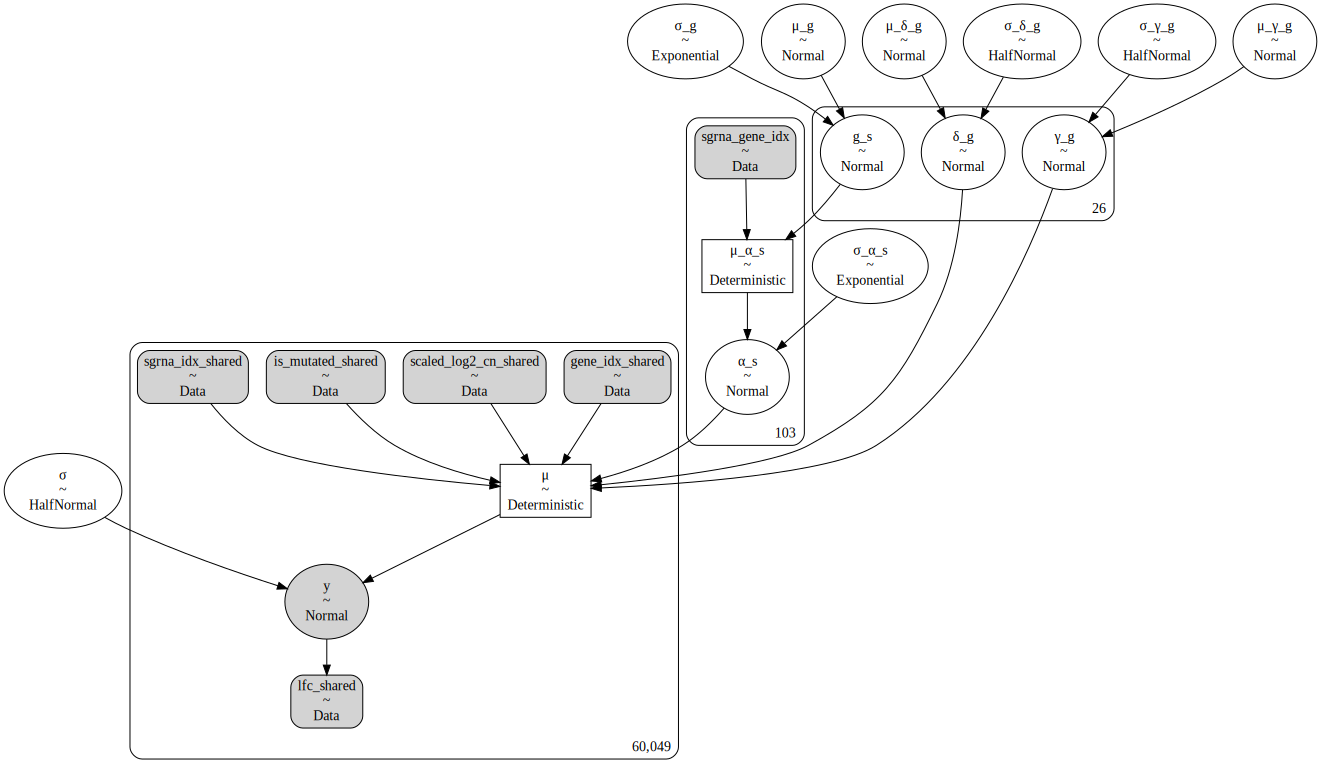

In [6]:
pm.model_to_graphviz(m7)

# TODO: Implement the KRAS covariates.

---

In [2]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.00 minutes


In [3]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-20

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: data-subset-model

theano    : 1.0.5
matplotlib: 3.3.3
plotnine  : 0.7.1
pymc3     : 3.9.3
numpy     : 1.19.5
re        : 2.2.1
pandas    : 1.2.0
arviz     : 0.11.0

